# Objectives

- [x] get data from database
- [ ] data wrangling
- [ ] ml model 
- [ ] compare with traditional prediction

# source

 data provided by Openweathermap

# settings

In [71]:
# settings
# display all outputs
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
#To revert to the original setting :
# InteractiveShell.ast_node_interactivity = "last_expr"

# Imports

In [128]:
# os
import os

#import time
import time
import datetime as dt

#googlesheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g

# data analysis and wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random 

# visualization and reporting
import pandas_profiling # dataframe profiling @
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import calmap

# Humid air model
from media_model_humid_air import h_humid_air,T_dew, rho_Humid_air, Ha_air


# Data imports

## Historical weather 

### google sheet authentication

In [73]:
#authentication to google api using JSON credential file
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('api_data/WDcred.json', scope)
client = gspread.authorize(creds)

### get data

In [74]:
#get historical weather berlin sheet
hist_weather = client.open('current_weather_berlin').sheet1

data = hist_weather.get_all_values()
headers = data.pop(0)

df_historical = pd.DataFrame(data, columns=headers)

In [75]:
#df_historical.tail()

## get Openweathermap forecast 

###  Authentication

In [76]:
#authentication to google api using JSON credential file
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('api_data/WDcred2.json', scope)
client = gspread.authorize(creds)

### Get Data

In [77]:
# open workbook
forecast_weather = client.open('forecast_weather_berlin')

In [78]:
#see all worksheets
#forecast_weather.worksheets()

[<Worksheet '6 th' id:1595407820>,
 <Worksheet '0 th' id:515115632>,
 <Worksheet '1 th' id:1164675889>,
 <Worksheet '2 th' id:136134104>]

In [79]:
# dataframe dictionary with all data
my_dfs={}
for worksheet in forecast_weather.worksheets():
    data = worksheet.get_all_values()
    headers = data.pop(0)
    name = str(worksheet)
    name = "df_"+name.split("'")[1].split(" ")[0]  
    df = pd.DataFrame(data, columns=headers)
    my_dfs[name]=df
  

In [80]:
#display data
if False:
    for key in my_dfs.keys():
        print(40*'-'+'\n'+key)
        my_dfs[key].head(5)
        print(40*'-')

In [81]:
df_hist=df_historical
my_dfs2=my_dfs

In [87]:
df_historical.tail()

,datetime,temperature,humidity,pressure,windspeed,winddir,cloudcoverage,rain,snow,weather,description
465,2020-04-08 08:34:55,9.73,53,1030,2.6,70,3,0,0,Clear,clear sky
466,2020-04-08 09:36:05,12.88,47,1030,5.1,130,0,0,0,Clear,clear sky
467,2020-04-08 10:33:15,14.8,44,1029,4.1,110,1,0,0,Clear,clear sky
468,2020-04-08 11:30:55,16.61,42,1029,3.6,120,1,0,0,Clear,clear sky
469,2020-04-08 12:31:39,19.59,39,1028,3.1,140,1,0,0,Clear,clear sky


# Wrangle

## get ride of sunrise and sunset

In [83]:
df_hist.drop('sunrisetime',axis =1, inplace=True)
df_hist.drop('sunsettime',axis =1, inplace=True)

## df_forecast column rename 

In [84]:
for key in my_dfs2.keys():
    my_dfs2[key].rename(columns={
        '':'datetime',
        "temp": "temperature",
        "humidity": "humidity",
        "pressure": "pressure",
        "wind_speed": "windspeed",
        "wind_dir": "winddir",
        "rain3h":"rain",
        "snow3h":"snow",
        "cloudcoverage": "cloudcoverage",
        "weather": "weather",
        "description": "description",
        "icon": "weathericon"},inplace=True)
#df_fore.columns

## join df

In [85]:
name='df_c'
my_dfs2[name]=df_hist

## drop icon

In [86]:
for key in my_dfs2.keys():
    my_dfs2[key].drop('weathericon',axis =1, inplace=True)

## string to numeric values

In [88]:
for key in my_dfs2.keys():
    cols=['temperature', 'humidity', 'pressure', 'windspeed','winddir','cloudcoverage','rain','snow']
    for col in cols:
        my_dfs2[key][col]= pd.to_numeric(my_dfs2[key][col], errors='coerce')

## String to datetime

In [89]:
for key in my_dfs2.keys():
    my_dfs2[key]['datetime']= pd.to_datetime(my_dfs2[key]['datetime'], errors='coerce') 

## weather and description

In [90]:
for key in my_dfs2.keys():
    my_dfs2[key]['weather_description']=my_dfs2[key]['weather']+' : '+my_dfs2[key]['description']
    my_dfs2[key].drop(['weather','description'],axis=1,inplace=True)

## Deal with Na

In [91]:
for key in my_dfs2.keys():
    my_dfs2[key]['winddir'].fillna(399,inplace=True)

## Creation new value

In [92]:
for key in my_dfs2.keys():  
    # absolute humidity
    my_dfs2[key]['humidity_abs']=round(my_dfs2[key].apply(lambda x: Ha_air(x['temperature']+273.15,x['humidity']),axis=1),4)
    # entalpy
    my_dfs2[key]['enthalpy']=round(my_dfs2[key].apply(lambda x: h_humid_air(x['temperature']+273.15,x['humidity']),axis=1))
    # dew point
    my_dfs2[key]['dewpoint']=round(my_dfs2[key].apply(lambda x: T_dew(x['temperature']+273.15,x['humidity']),axis=1)-273.15,2)
    # density
    my_dfs2[key]['density']=round(my_dfs2[key].apply(lambda x: rho_Humid_air(x['temperature']+273.15,x['humidity']),axis=1),3)

In [93]:
#display data
if False:
    for key in my_dfs2.keys():
        print(40*'-'+'\n'+key)
        my_dfs2[key].head(5)
        print(40*'-')

In [94]:
my_dfs2['df_c'].head()

,datetime,temperature,humidity,pressure,windspeed,winddir,cloudcoverage,rain,snow,weather_description,humidity_abs,enthalpy,dewpoint,density
0,2020-03-19 11:45:50,13.91,71,1025,4.1,290.0,75,0.0,0.0,Clouds : broken clouds,0.0070,32.0,8.79,1.224
1,2020-03-19 12:50:48,13.81,67,1025,3.6,330.0,75,0.0,0.0,Clouds : broken clouds,0.0065,31.0,7.85,1.225
2,2020-03-19 13:46:46,13.48,71,1025,3.6,350.0,75,0.0,0.0,Clouds : broken clouds,0.0068,31.0,8.38,1.226
3,2020-03-19 14:52:21,13.65,67,1025,3.1,360.0,40,0.0,0.0,Clouds : scattered clouds,0.0065,30.0,7.70,1.226
4,2020-03-19 15:52:40,13.26,71,1025,3.6,340.0,40,0.0,0.0,Clouds : scattered clouds,0.0067,30.0,8.17,1.227


## Data report

In [95]:
# long
#profile report inline

if False: # Train Data report generation
    for key in my_dfs2.keys():
        title="Berlin Weather Data "+str(key)
        output_file="profile_report/Berlin Weather Data "+str(key)+".html"
        profile = my_dfs2[key].profile_report(title=title) 
        profile.to_file(output_file=output_file) # save the report 


In [96]:
# short
if False: # hist report
    for key in my_dfs2.keys():
        my_dfs2[key].head()
        my_dfs2[key].info()
        my_dfs2[key].describe(include='all')
        
my_dfs2['df_c'].info()    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             470 non-null    datetime64[ns]
 1   temperature          470 non-null    float64       
 2   humidity             470 non-null    int64         
 3   pressure             470 non-null    int64         
 4   windspeed            470 non-null    float64       
 5   winddir              470 non-null    float64       
 6   cloudcoverage        470 non-null    int64         
 7   rain                 470 non-null    float64       
 8   snow                 470 non-null    float64       
 9   weather_description  470 non-null    object        
 10  humidity_abs         470 non-null    float64       
 11  enthalpy             470 non-null    float64       
 12  dewpoint             470 non-null    float64       
 13  density              470 non-null  

## Heat map

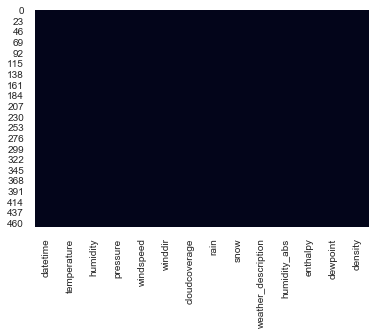

In [97]:
sns.heatmap(my_dfs2['df_c'].isnull(), cbar=False)

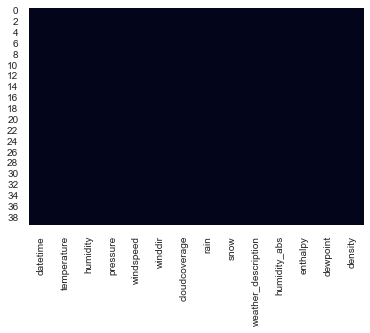

In [98]:
sns.heatmap(my_dfs2['df_6'].isnull(), cbar=False)

# Display

In [ ]:
my_disp_dfs=my_dfs2
for key in my_disp_dfs.keys():
    my_disp_dfs[key].set_index('datetime',inplace=True)
    

In [126]:
# last 14 days    
my_disp_dfs['df_c']=my_disp_dfs['df_c'].loc[my_disp_dfs['df_c'].index>=my_disp_dfs['df_c'].index.max()-]

<Figure size 864x432 with 0 Axes>

Text(0.5, 0, 'datetime')

Text(0, 0.5, 'Temperature [°C]')

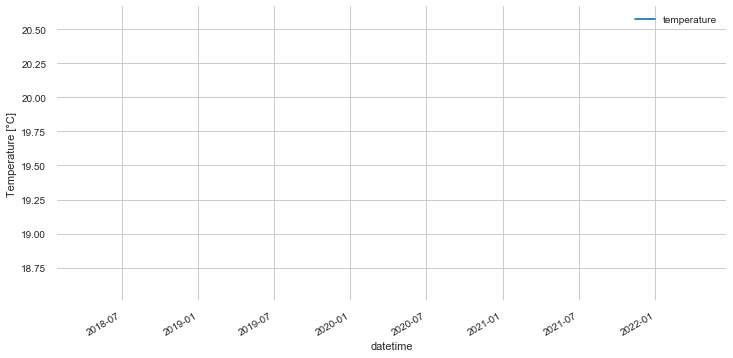

In [127]:
plt.figure(figsize=(12,6))
my_dfs2['df_c'].temperature.plot()
plt.xlabel('datetime')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid()
plt.show()